In [7]:
mass = 3 #kg
gravity = 10 #m/s^2
magnet_force = 1000 #N
percent_weight_on_wheels = 0.8

normal_on_wheel = (mass * gravity + magnet_force) * percent_weight_on_wheels / 2

friction_coef_wheel = 1.0
max_force_on_wheel = normal_on_wheel * friction_coef_wheel
print(f'Maximum force wheel can excert before sliping is {max_force_on_wheel} N')


Maximum force wheel can excert before sliping is 412.0 N


In [8]:
wheel_radius = 0.02 #40mm diameter
max_torque_on_wheel = max_force_on_wheel * wheel_radius
print(f'Maximum torque wheel can excert before sliping is {max_torque_on_wheel} N.m')

Maximum torque wheel can excert before sliping is 8.24 N.m


In [9]:
gear_ratio = 50/13
max_torque_on_motor = max_torque_on_wheel / gear_ratio
print(f'Maximum torque on motor is {max_torque_on_motor} N.m')

Maximum torque on motor is 2.1424 N.m


## From Maxon DCX35L  18V Datasheet
Stall Current = 84.8 A

Torque Constant = 23.4 mNm/A

Speed Constant = 408 RPM/V

Speed/torque gradient =  3.7 RPM/mNm

Rotor inertia = 102 gcm^2

Terminal resistance = 0.212 Ohn

In [136]:
motor_resistance = 0.212
kv = 408/60
kt = 23.4 / 1000
motor_L = 0.077 / 1000
def getMotorTorque(voltage_input, motor_rotation, current_derivative = 0):    
    current = (voltage_input-motor_rotation/kv - current_derivative * motor_L) /motor_resistance
    rotor_torque = current * kt
    return rotor_torque, current

In [99]:
rs775_resistance = 42/46.17
rs775_kv = 345/60
rs775_kt = 0.028
def get775Torque(voltage_input, motor_rotation):
    current = (voltage_input-motor_rotation/rs775_kv) /rs775_resistance
    rotor_torque = current * rs775_kt
    return rotor_torque, current

In [10]:
from matplotlib import pyplot as plt

Stable at 0.0054 seconds, with 54 steps


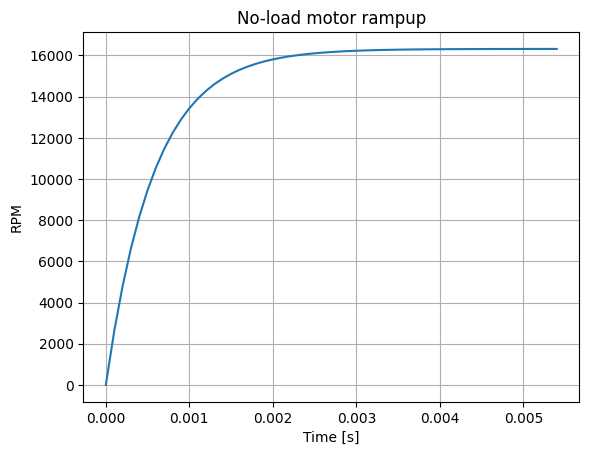

In [134]:
# Motor no-load simulation
timestep = 0.0001 #s
motor_a = [0]
motor_rotation = [0]
motor_torque = [0]
voltage = 40
motor_inertia = 102 /1000 /100/100
vt_grad = 3.7 / 60
motor_rpm = [0]
t = [0]
unstable = 2
i = 0
while unstable:
    motor_rotation.append(motor_rotation[-1]+motor_a[-1]*timestep)
    step_torque, _ = getMotorTorque(voltage, motor_rotation[-1])
    motor_torque.append(step_torque)
    motor_a.append(step_torque/motor_inertia)
    motor_rpm.append(motor_rotation[-1]*60)
    t.append(i*timestep)
    if len(t)>10 and (max(motor_rotation[-10:]) - min(motor_rotation[-10:])) < 0.1:
        unstable = 0
        print(f"Stable at {t[-1]} seconds, with {i} steps")
    i+=1
plt.plot(t, motor_rpm)
plt.title("No-load motor rampup")
plt.ylabel("RPM")
plt.xlabel("Time [s]")
plt.grid()





Stable at 0.0135 seconds, with 135 steps


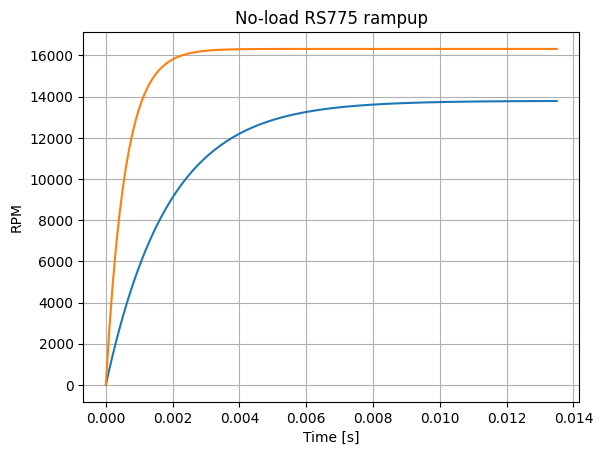

In [115]:
# Motor no-load simulation
compare_rpm = motor_rpm.copy()
timestep = 0.0001 #s
motor_a = [0]
motor_rotation = [0]
motor_torque = [0]
voltage = 40
motor_inertia = 102 /1000 /100/100
motor_rpm = [0]
t = [0]
unstable = 2
i = 0
while unstable:
    motor_rotation.append(motor_rotation[-1]+motor_a[-1]*timestep)
    step_torque, _ = get775Torque(voltage, motor_rotation[-1])
    motor_torque.append(step_torque)
    motor_a.append(step_torque/motor_inertia)
    motor_rpm.append(motor_rotation[-1]*60)
    t.append(i*timestep)
    if len(t)>10 and (max(motor_rotation[-10:]) - min(motor_rotation[-10:])) < 0.1:
        unstable = 0
        print(f"Stable at {t[-1]} seconds, with {i} steps")
    i+=1
while(len(compare_rpm)<len(t)):
    compare_rpm.append(compare_rpm[-1])
plt.plot(t, motor_rpm)
plt.plot( t, compare_rpm)
plt.title("No-load RS775 rampup")
plt.ylabel("RPM")
plt.xlabel("Time [s]")
plt.grid()


Stable at 0.003 seconds, with 3000 steps


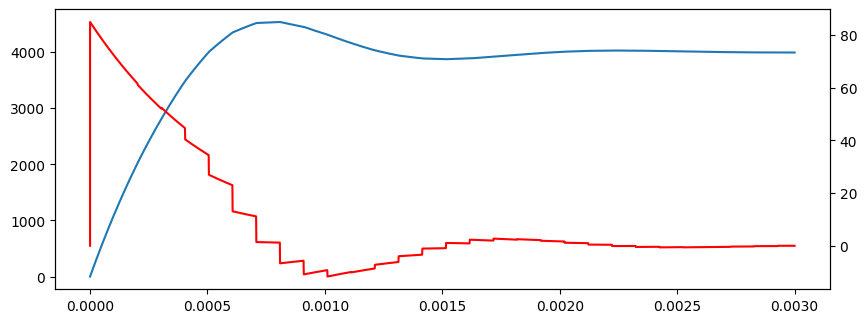

In [160]:
# Speed controller
freq_setpoint = 4000/60
timestep = 0.000001 #s
motor_a = [0]
motor_rotation = [0]
motor_torque = [0]
motor_current=[0]
voltage = 18
motor_inertia = 102 /1000 /100/100
motor_rpm = [0]
t = [0]
unstable = 2
i = 0

controller_period = 0.0001
Kp = 0.01
Ki = 100
error_integral = 0
controller_tick = -1
controller_output = 0
controller_output_saturation = 0
controller_past_error = 0
while unstable:
    motor_rotation.append(motor_rotation[-1]+motor_a[-1]*timestep)
### Controller
    if t[-1] > controller_tick + controller_period:
        error = freq_setpoint - motor_rotation[-1]
        if not controller_output_saturation:
            error_integral += error * controller_period
        error_derivative = error-controller_past_error / controller_period


        controller_output = error * Kp + error_integral * Ki 
        controller_tick = t[-1]
        controller_past_error = error
        if controller_output > 1:
            controller_output = 1
            controller_output_saturation = 1
        elif controller_output < -1:
            controller_output = -1
            controller_output_saturation = 1
        else:
            controller_output_saturation = 0
###
    

    step_torque, step_current = getMotorTorque(voltage * controller_output, motor_rotation[-1]) 
    # step_torque -= 0.5
    motor_torque.append(step_torque)
    motor_a.append(step_torque/(motor_inertia))
    motor_rpm.append(motor_rotation[-1]*60)
    motor_current.append(step_current)
    t.append(i*timestep)
    if len(t)>100 and (max(motor_rotation[-100:]) - min(motor_rotation[-100:])) < 0.01:
        unstable = 0
        print(f"Stable at {t[-1]} seconds, with {i} steps")
    elif i==10000000: #max steps
        unstable = 0
    i+=1

plt.figure(figsize=(10,8))
ax0 = plt.subplot(211)
ax1 = ax0.twinx()
ax0.plot(t, motor_rpm)
ax1.plot(t, motor_current, "red")
plt.show()